Este cuaderno incluye el código utilizado para el experimento: «Preprocesamiento de datos» correspondiente a la sección 3.2.3

# Módulos

In [306]:
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.processors import CentreOfRotationCorrector, Slicer, \
    Binner, Masker, MaskGenerator, TransmissionAbsorptionConverter

from cil.plugins.astra import FBP

from cil.utilities import dataexample
from cil.utilities.display import show2D, show_geometry

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, matshow, show, colorbar, axis
import logging

logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

In [307]:
cmap = "magma"

# Preprocesamiento de datos

## Carga de datos

In [308]:
data_raw = dataexample.SYNCHROTRON_PARALLEL_BEAM_DATA.get()

print(data_raw)

Number of dimensions: 3
Shape: (91, 135, 160)
Axis labels: ('angle', 'vertical', 'horizontal')



In [309]:
print(data_raw.geometry)

3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [160 135]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 91
	Angles 0-20 in degrees:
[-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   , -68.2   , -66.2   , -64.1999, -62.2   ,
 -60.2   , -58.2   , -56.2   , -54.2   , -52.2   , -50.2   ]
Distances in units: units distance


(-0.5, 159.5, 134.5, -0.5)

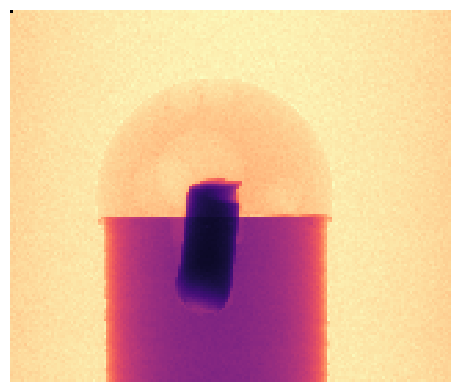

In [310]:
matshow(data_raw.as_array()[15, :, :], cmap='magma')
axis('off')

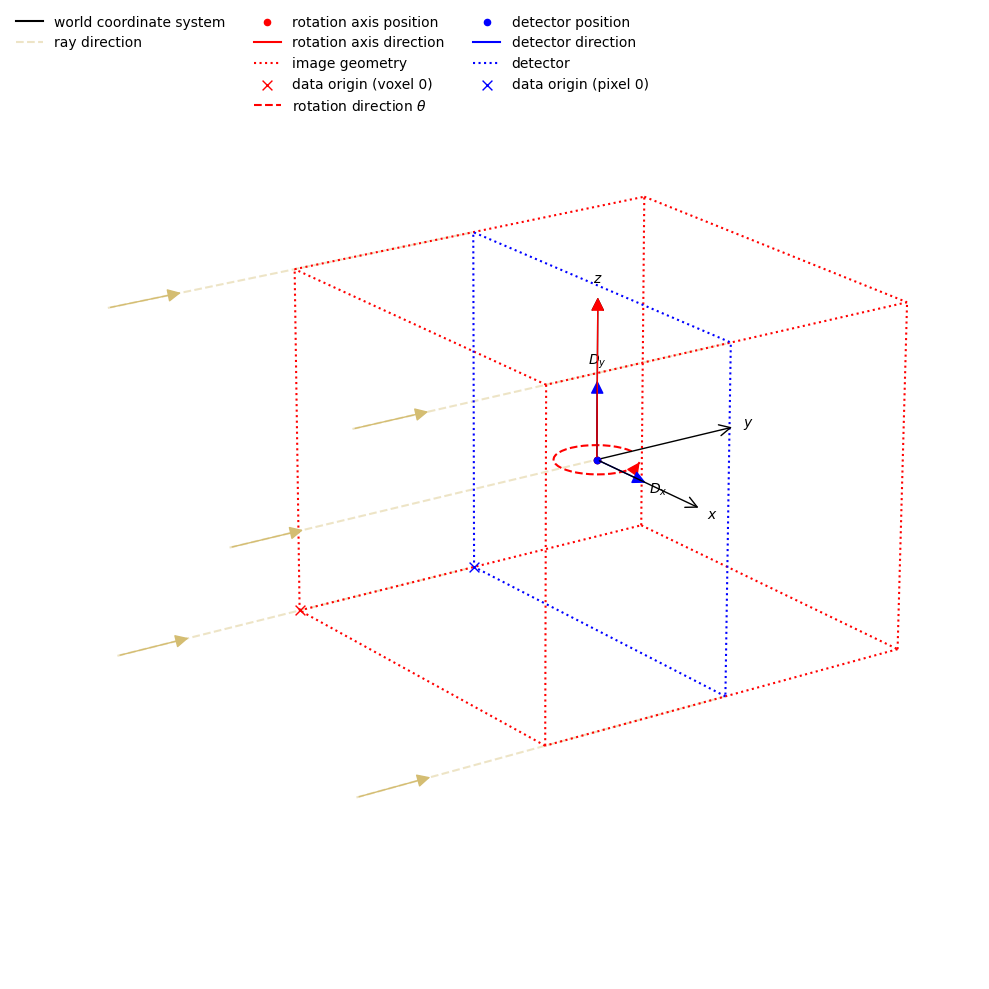

In [311]:
# and show geometry
show_geometry(data_raw.geometry)

Convertimos los datos a modo absorción

(-0.5, 159.5, 134.5, -0.5)

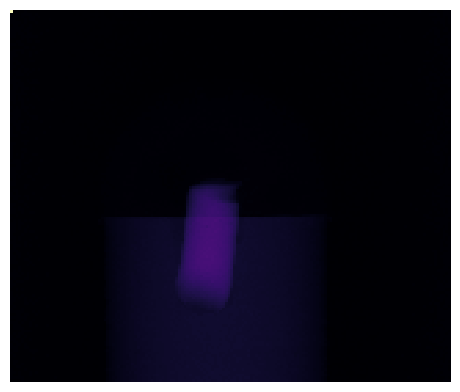

In [312]:
background = data_raw.get_slice(vertical=20).mean()
data_raw /= background

data_exp = TransmissionAbsorptionConverter()(data_raw)

matshow(data_exp.as_array()[15, :, :], cmap='magma')
axis('off')

(-0.5, 159.5, 134.5, -0.5)

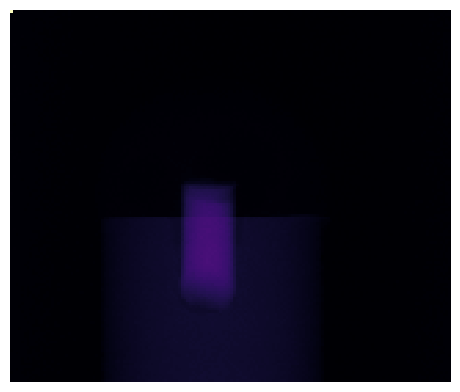

In [313]:
matshow(data_exp.as_array()[30, :, :], cmap='magma')
axis('off')

In [314]:
data_crop = Slicer(roi={'vertical': (1, None)})(data_exp)

Definimos un umbral para la eliminación de los valores atípicos

(-0.5, 159.5, 134.5, -0.5)

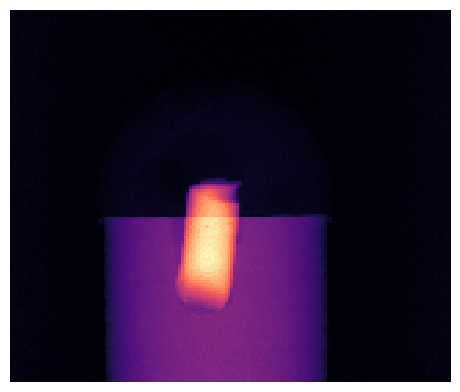

In [315]:
mask = MaskGenerator.threshold(max_val=10)(data_exp)

data_masked = Masker.interpolate(mask=mask, method='nearest', axis='vertical')(data_exp)

matshow(data_masked.as_array()[15, :, :], cmap='magma')
axis('off')

## Corrección avanzada de pixeles defectuosos

In [316]:
def add_bad_pixels(data, number_of_columns, number_of_hot_pix, seed):

    data_corrupted = data.copy()

    # get intensity range
    low = np.amin(data.as_array())
    high = np.amax(data.as_array())

    # we seed random number generator for repeatability
    rng = np.random.RandomState(seed=seed) 
    # indices of bad columns
    columns = rng.randint(0, data.shape[1], size=number_of_columns)
    # indices of hot pixels
    pix_row = rng.randint(0, data.shape[0], size=number_of_hot_pix)
    pix_col = rng.randint(0, data.shape[1], size=number_of_hot_pix)
    # values in hot pixels
    pixel_values = rng.uniform(low=low, high=high, size=number_of_hot_pix)

    for i in range(number_of_columns):
        col_pattern = rng.uniform(low=low, high=high, size=data.shape[0])
        data_corrupted.as_array()[:, columns[i]] = data.as_array()[:, columns[i]]+col_pattern

    for i in range(number_of_hot_pix):
        data_corrupted.as_array()[pix_row[i], pix_col[i]] = pixel_values[i]

    return data_corrupted    

In [317]:
number_of_columns = 5
number_of_hot_pix = 200
seed = 8392

data_corrupted = add_bad_pixels(data_slice, number_of_columns, number_of_hot_pix, seed)

(-0.5, 119.5, 89.5, -0.5)

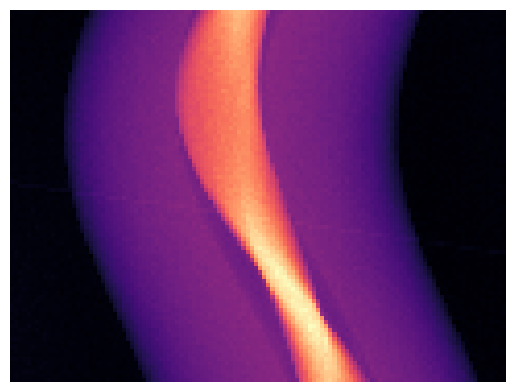

In [318]:
matshow(data_slice.as_array(), cmap='magma')
axis('off')

(-0.5, 119.5, 89.5, -0.5)

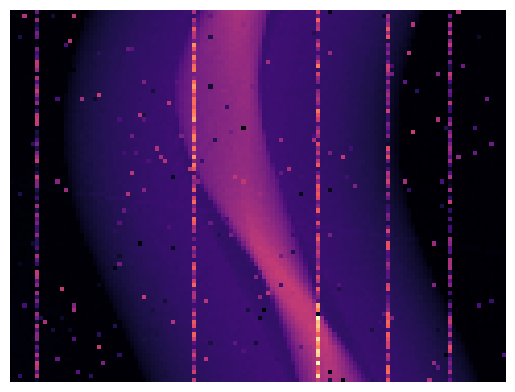

In [319]:
matshow(data_corrupted.as_array(), cmap='magma')
axis('off')

In [320]:
fbp = FBP(ig_slice, data_slice.geometry, device='gpu')
fbp.set_input(data_slice)
fbp_recon_clean = fbp.get_output()  

fbp.set_input(data_corrupted)
fbp_recon_corrupted = fbp.get_output() 

(-0.5, 119.5, 119.5, -0.5)

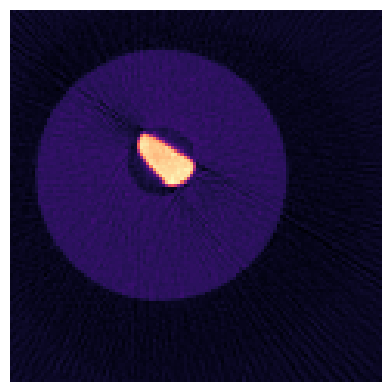

In [321]:
matshow(fbp_recon_clean.as_array(), cmap='magma')
axis('off')

(-0.5, 119.5, 119.5, -0.5)

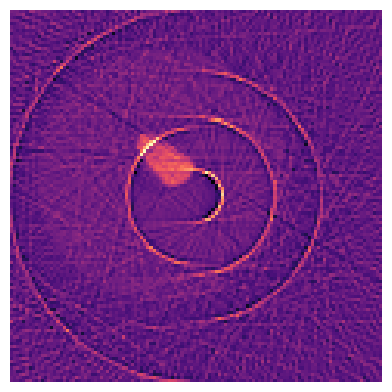

In [322]:
matshow(fbp_recon_corrupted.as_array(), cmap='magma')
axis('off')

In [323]:
mask = MaskGenerator.median(threshold_factor=3, window=7)(data_corrupted)
data_masked = Masker.interpolate(mask=mask, method='linear', axis='horizontal')(data_corrupted)

(-0.5, 119.5, 89.5, -0.5)

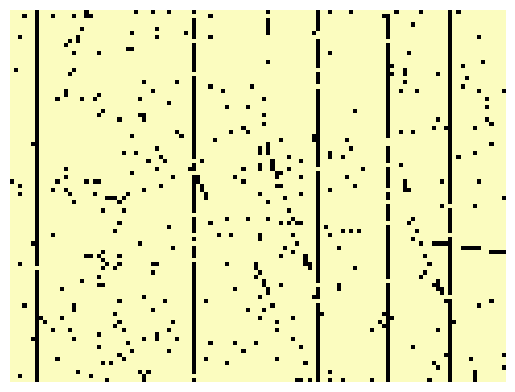

In [324]:
matshow(mask.as_array(), cmap='magma')
axis('off')

(-0.5, 119.5, 89.5, -0.5)

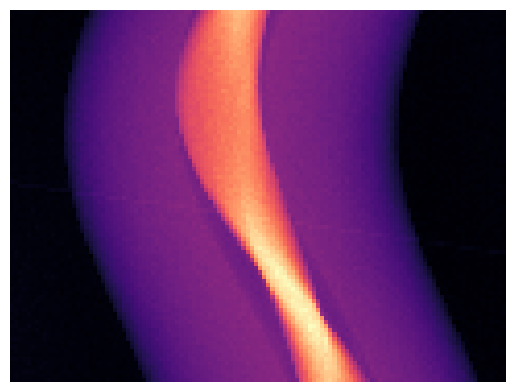

In [325]:
matshow(data_slice.as_array(), cmap='magma')
axis('off')

(-0.5, 119.5, 89.5, -0.5)

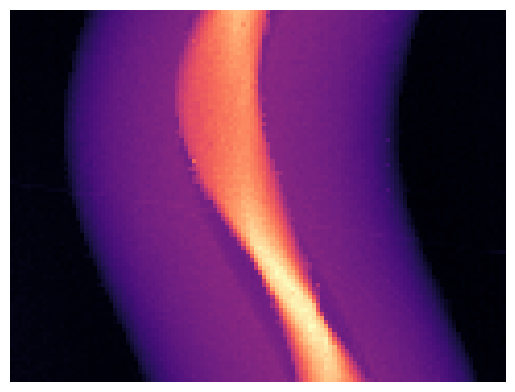

In [326]:
matshow(data_masked.as_array(), cmap='magma')
axis('off')

(-0.5, 119.5, 89.5, -0.5)

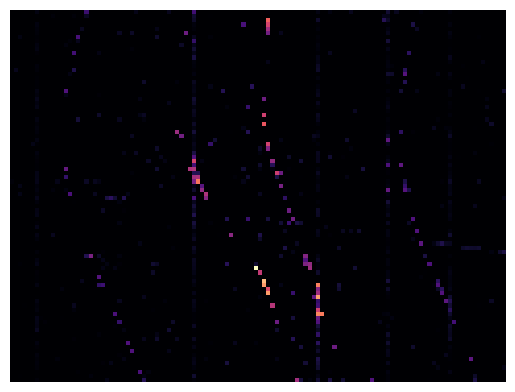

In [327]:
matshow(np.abs(data_slice.as_array()-data_masked.as_array()), cmap='magma')
axis('off')

In [328]:
fbp.set_input(data_masked)
fbp_recon_masked = fbp.get_output()  

(-0.5, 119.5, 119.5, -0.5)

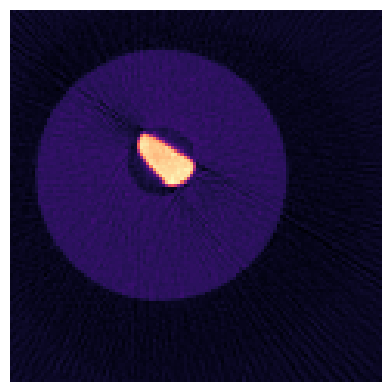

In [329]:
matshow(fbp_recon_clean.as_array(), cmap='magma')
axis('off')

(-0.5, 119.5, 119.5, -0.5)

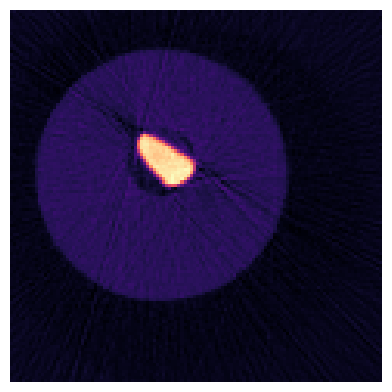

In [330]:
matshow(fbp_recon_masked.as_array(), cmap='magma')
axis('off')